## Zero noise extrapolation with mitiq on Amazon Braket

In this notebook, we look at a 

In [1]:
from mitiq.zne import construct_circuits

from braket.circuits import Circuit
from braket.devices import LocalSimulator
from braket.emulation.local_emulator import LocalEmulator
from qiskit import QuantumCircuit
from qiskit import transpile

import numpy as np 
from braket.emulation.local_emulator import LocalEmulator
import json

with open("emerald_properties_251106.json","r") as fp:
    props = json.load(fp)

emulator = LocalEmulator.from_json(props)
qd = LocalSimulator("braket_dm",noise_model= emulator._noise_model)

# target = aws_device_to_target(qd)


In [32]:
from mitiq.zne import construct_circuits
from qiskit_braket_provider import to_braket, to_qiskit
from math import pi 

def rxx_pi4(i,j):
    cx = Circuit().h(i).cnot(i,j).h(i).rx(i,pi/8).rx(j,pi/8)
    return cx

def ising_1d(self_interaction : float, num_qubits : int) -> Circuit:
    circ = Circuit()
    for i in range(num_qubits):
        circ.ry(i,self_interaction)
    for i in range(0,num_qubits-1,2):
        circ+= rxx_pi4(i,i+1)
    for i in range(1,num_qubits-1,2):
        circ+= rxx_pi4(i,i+1)
    # circ = to_braket(
    #     to_qiskit(
    #         circ, add_measurements=False), 
    #         basis_gates=["cz","r"], 
    #         optimization_level=1)
    return circ

test = ising_1d(0.1,10)
print(test)


T  : │     0      │  1  │  2  │     3      │     4      │  5  │     6      │     7      │
      ┌──────────┐ ┌───┐          ┌───┐     ┌──────────┐                                 
q0 : ─┤ Ry(0.10) ├─┤ H ├───●──────┤ H ├─────┤ Rx(0.39) ├─────────────────────────────────
      └──────────┘ └───┘   │      └───┘     └──────────┘                                 
      ┌──────────┐       ┌─┴─┐ ┌──────────┐    ┌───┐              ┌───┐     ┌──────────┐ 
q1 : ─┤ Ry(0.10) ├───────┤ X ├─┤ Rx(0.39) ├────┤ H ├───────●──────┤ H ├─────┤ Rx(0.39) ├─
      └──────────┘       └───┘ └──────────┘    └───┘       │      └───┘     └──────────┘ 
      ┌──────────┐ ┌───┐          ┌───┐     ┌──────────┐ ┌─┴─┐ ┌──────────┐              
q2 : ─┤ Ry(0.10) ├─┤ H ├───●──────┤ H ├─────┤ Rx(0.39) ├─┤ X ├─┤ Rx(0.39) ├──────────────
      └──────────┘ └───┘   │      └───┘     └──────────┘ └───┘ └──────────┘              
      ┌──────────┐       ┌─┴─┐ ┌──────────┐    ┌───┐              ┌───┐     ┌──────────┐ 
q3 : ─┤ Ry

In [41]:
import matplotlib.pyplot as plt 
from braket.circuits.observables import Z
np.set_printoptions(linewidth=400,precision=3,suppress=True)

qd_exact = LocalSimulator()
obs = Circuit()
for i in range(10):
    obs.expectation(Z(i))

circ = Circuit()
ideal_evs = []
ideal_stds = []
for steps in range(10):
    circ+= test + test
    res = qd_exact.run(circ + obs, shots = 0).result()
    ideal_evs.append(res.values)


dat = np.array(ideal_evs)
dat.shape



(10, 10)

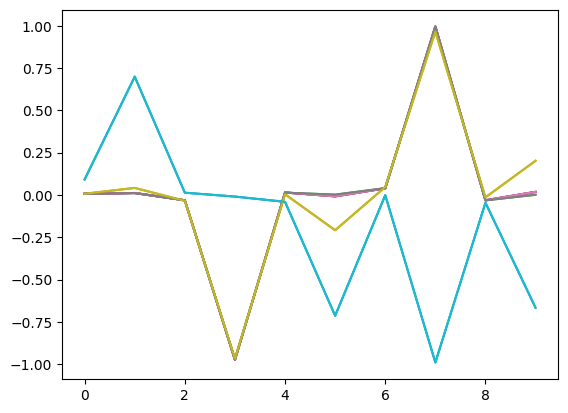

In [34]:
# plt.errorbar(range(len(ideal_evs)), ideal_evs, ideal_stds, capsize=3, marker='x',linewidth=1)
for i in range(10):
    plt.plot(range(10), dat[:,i])

In [42]:
obs = Circuit()
for i in range(10):
    obs.expectation(Z(i))

noisy_circ = Circuit()
noisy_evs = []
for steps in range(10):
    print(steps)
    noisy_circ+= test + test
    ncirc = to_braket(
        to_qiskit(
            noisy_circ, add_measurements=False), 
            basis_gates=["cz","r"], 
            optimization_level=0)

    res = qd.run(ncirc + obs, shots = 10000).result()
    noisy_evs.append(res.values)

noisy_evs = np.array(noisy_evs)

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Expectation Value')

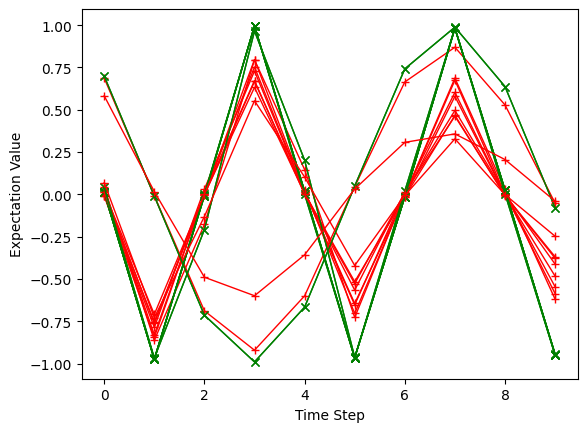

In [45]:
for i in range(10):
    plt.plot(range(10), dat[:,i], marker='x',linewidth=1, c = 'g',
                label=f"ideal: <Z({i})>"
                )
    plt.plot(range(0,len(noisy_evs)), noisy_evs[:,i], marker='+',c='r',linewidth=1,
                label=f"noisy: <Z({i})>")
plt.xlabel("Time Step")
plt.ylabel("Expectation Value")

In [62]:
from mitiq.zne import construct_circuits 
import numpy as np 

obs = Circuit()
for i in range(10):
    obs.expectation(Z(i))

circ=  Circuit()
zne_evs = np.zeros((10,3,10))
for steps in range(10):
    print(steps)
    circ+= test + test
    circuits = construct_circuits(circ, [1.0, 1.75, 2.5])
    temp = np.zeros((10,3))
    for j,item in enumerate(circuits):
        ncirc = to_braket(
            to_qiskit(
                item, add_measurements=False), 
                basis_gates=["cz","r"], 
                optimization_level=0)

        res = qd.run(ncirc + obs, shots = 10000).result()
        zne_evs[steps,j,:] = res.values

0


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 3.141592653589793 will not be included in Braket circuit
  warnings.warn(
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 3.141592653589793 will not be included in Braket circuit
  warnings.warn(


1


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 3.141592653589793 will not be included in Braket circuit
  warnings.warn(


2


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 3.141592653589793 will not be included in Braket circuit
  warnings.warn(
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 3.141592653589793 will not be included in Braket circuit
  warnings.warn(


3


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 3.141592653589793 will not be included in Braket circuit
  warnings.warn(


4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 3.141592653589793 will not be included in Braket circuit
  warnings.warn(


5
6


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 3.141592653589793 will not be included in Braket circuit
  warnings.warn(


7


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 3.141592653589793 will not be included in Braket circuit
  warnings.warn(


8


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 3.141592653589793 will not be included in Braket circuit
  warnings.warn(


9


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 3.141592653589793 will not be included in Braket circuit
  warnings.warn(
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 3.141592653589793 will not be included in Braket circuit
  warnings.warn(


In [65]:
from mitiq.zne import combine_results
from mitiq.zne.inference import RichardsonFactory, ExpFactory, LinearFactory
extrapolated = []
for i in range(10):
    temp = []
    for j in range(10):
        temp.append(combine_results([1, 1.75, 2.5], zne_evs[i,:,j], RichardsonFactory.extrapolate))
    extrapolated.append(temp)

extrapolated = np.array(extrapolated)

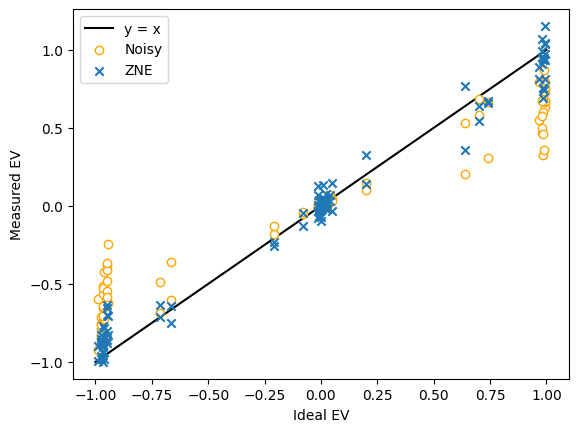

In [76]:
xs = np.linspace(-1,+1,51)
plt.plot(xs,xs,color='k',zorder=0, label="y = x")
plt.scatter(dat.flatten(), noisy_evs.flatten(), marker = 'o', facecolor='w', edgecolor='orange', label="Noisy")
plt.scatter(dat.flatten(), extrapolated.flatten(), label="ZNE", marker = 'x')
plt.xlabel("Ideal EV")
plt.ylabel("Measured EV")
plt.legend()

We can dive deeper into one of these extrapolation techniques using the extrapolate function.

First, let's inspect the noisy expectations themselves:

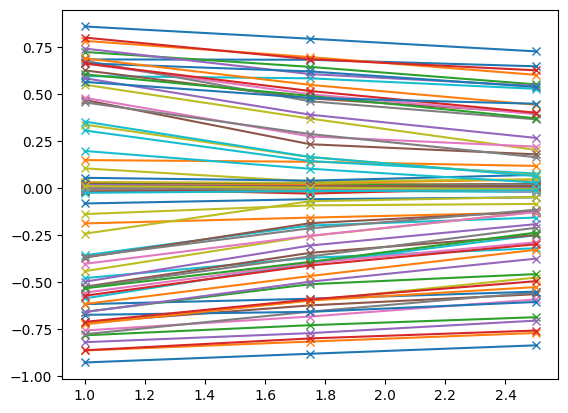

In [74]:
for i in range(10):
    for j in range(10):
        plt.plot([1,1.75, 2.5], zne_evs[i,:,j], marker = 'x')


In [ ]:
ex_richardson = []
ex_linear =  []

for i in range(10):
    temp = []
    for j in range(10):
        res = RichardsonFactory.extrapolate(
            [1, 1.5, 2.0], zne_evs[i,:,j], True)
        temp.append(res[0])
    ex_linear.append(temp)

extrapolated_richardson = np.array(extrapolated_richardson)

Circuit('instructions': [Instruction('operator': Ry('angle': 0.1, 'qubit_count': 1), 'target': QubitSet([Qubit(0)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Ry('angle': 0.1, 'qubit_count': 1), 'target': QubitSet([Qubit(1)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Ry('angle': 0.1, 'qubit_count': 1), 'target': QubitSet([Qubit(2)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Ry('angle': 0.1, 'qubit_count': 1), 'target': QubitSet([Qubit(3)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Ry('angle': 0.1, 'qubit_count': 1), 'target': QubitSet([Qubit(4)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Ry('angle': 0.1, 'qubit_count': 1), 'target': QubitSet([Qubit(5)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Ry('angle': 0.1, 'qubit_count': 1), 'target':